<a href="https://colab.research.google.com/github/jwal1024/Hedonic_DML/blob/main/DoubleML_and_Feature_Engineering_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT

## Preliminaries


In [1]:
%%capture
# Huggingface NLP transforms, and standard ML tool kits
!pip install transformers
!pip install shap
!pip install tensorflow_addons
!pip install livelossplot
!pip install sqldf
!pip install auto-sklearn
!pip install -U scikit-learn
!pip install skimpy
!pip install statsmodels

In [2]:
# Load dependencies
import tensorflow as tf
import numpy as np
import pandas as pd
import sqldf as sql
import plotnine as p9; p9.theme_set(p9.theme_bw)
import skimpy
import statsmodels.api as sm # get full stats on regressions

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.formula.api as sm
from transformers import TFBertModel, BertTokenizer, DistilBertTokenizer, TFDistilBertModel
from transformers.models.bert.modeling_tf_bert import TFBertMainLayer

# Formatting tools
from pprint import pformat
np.set_printoptions(threshold=10)
import warnings
warnings.simplefilter('ignore')

In [3]:
# Function for sum of square residuals
ssq = lambda x: np.inner(x,x)
def get_r2(y,yhat):
    resids = yhat.reshape(-1) - y
    flucs = y - np.mean(y)
    print('RSS: {}, TSS + MEAN^2: {}, TSS: {}, R^2: {}'.format(ssq(resids), ssq(y), ssq(flucs), 1 - ssq(resids)/ssq(flucs)))

In [4]:
# Load TensorFlow, and ensure GPU is pressent
# The GPU will massively speed up neural network training
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [5]:
# Download text pre-processor ("tokenizer")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# Download BERT model
bert = TFBertModel.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

### Tokenization

The first step in using BERT (or any similar text embedding tool) is to *tokenize* the data. This step standardizes blocks of text, so that meaningless differences in text presentation don't affect the behavior of our algorithm.

Typically the text is transformed into a sequence of 'tokens,' each of which corresponds to a numeric code.

In [7]:
url = "https://github.com/jwal1024/Hedonic_DML/raw/main/ecom_sample_clean.parquet"
df = pd.read_parquet(url)

In [9]:
# Summarise the dataset
skimpy.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 298222 │ │ string      │ 3     │                                                          │
│ │ Number of columns │ 7      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │                                                          │
│                                │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0      ┃ p25    ┃ p50     ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Quantity        │   0 │      0 │   17.81 │   54.72 │       1 │      2 │       6 │    16 │   4848 │    ▇    │  │
│ │ revenue         │   0 │      0 │   33.12 │   103.2 │   0.001 │   5.78 │   14.85 │  29.7 │  11060 │    ▇    │  │
│ │ UnitPrice       │   0 │      0 │   3.298 │   20.77 │   0.001 │   1.25 │    2.08 │  4.13 │  11060 │    ▇    │  │
│ └─────────────────┴─────┴────────┴─────────┴─────────┴─────────┴────────┴─────────┴───────┴────────┴─────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ Date                   │      0 │         0 │     2010-12-01      │     2011-12-09      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ StockCode                 │       0 │          0 │                            1 │                   298222 │  │
│ │ Country                   │       0 │          0 │                          1.9 │                   555523 │  │
│ │ Description               │       0 │          0 │                          4.6 │                  1385865 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<Axes: title={'center': 'number of items sold and revenue over time'}, xlabel='Date'>

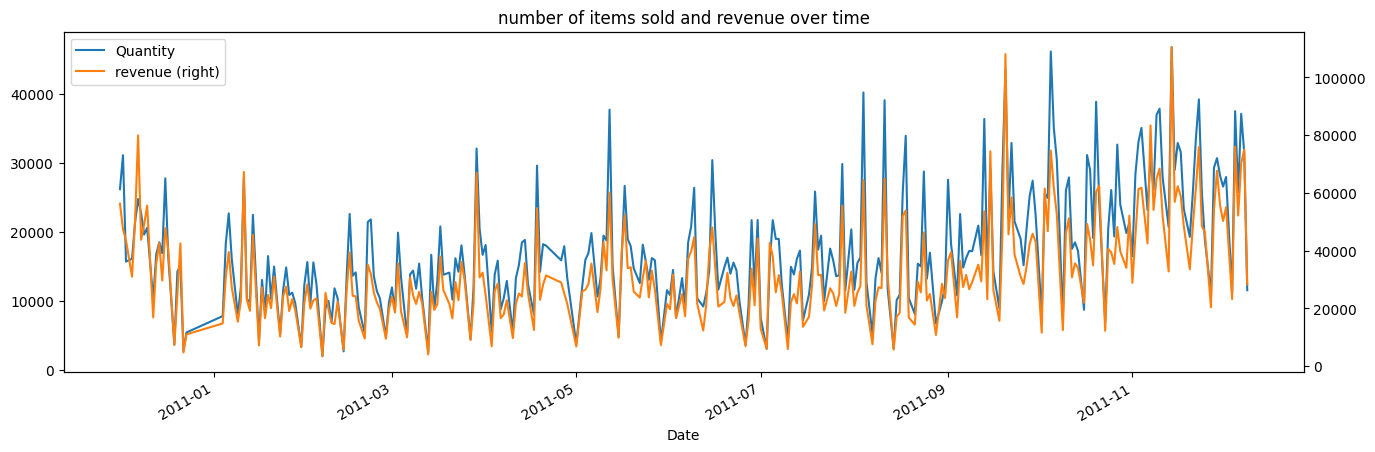

In [10]:
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title='number of items sold and revenue over time',
    secondary_y='revenue',
    figsize=(16, 5)
)

7.0


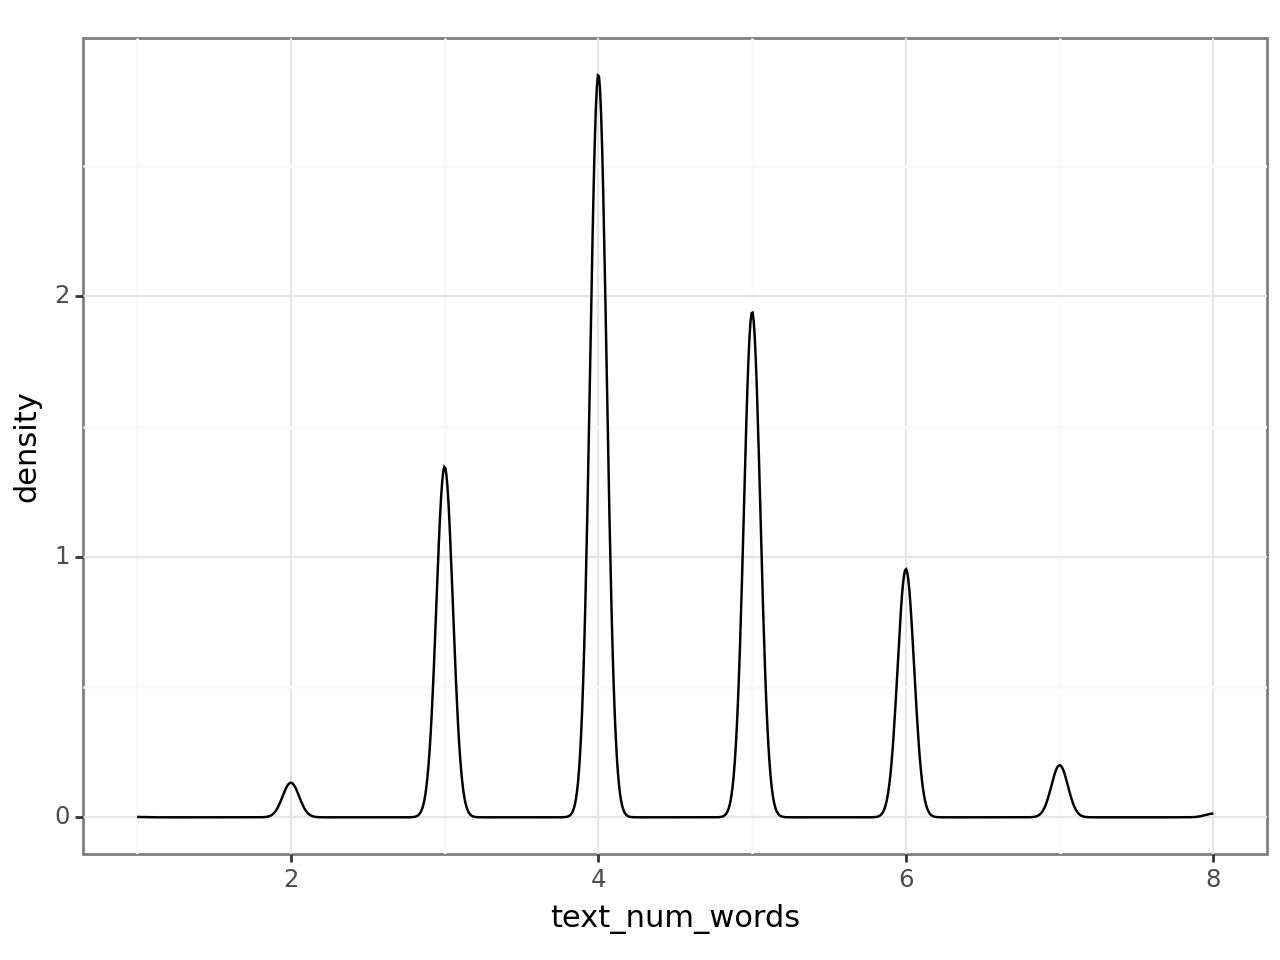

<Figure Size: (640 x 480)>

In [11]:
# Text lengths
df['text_num_words'] = df['Description'].str.split().apply(len)
print(np.nanquantile(df['text_num_words'], 0.99))
(p9.ggplot(df, p9.aes('text_num_words')) + p9.geom_density())

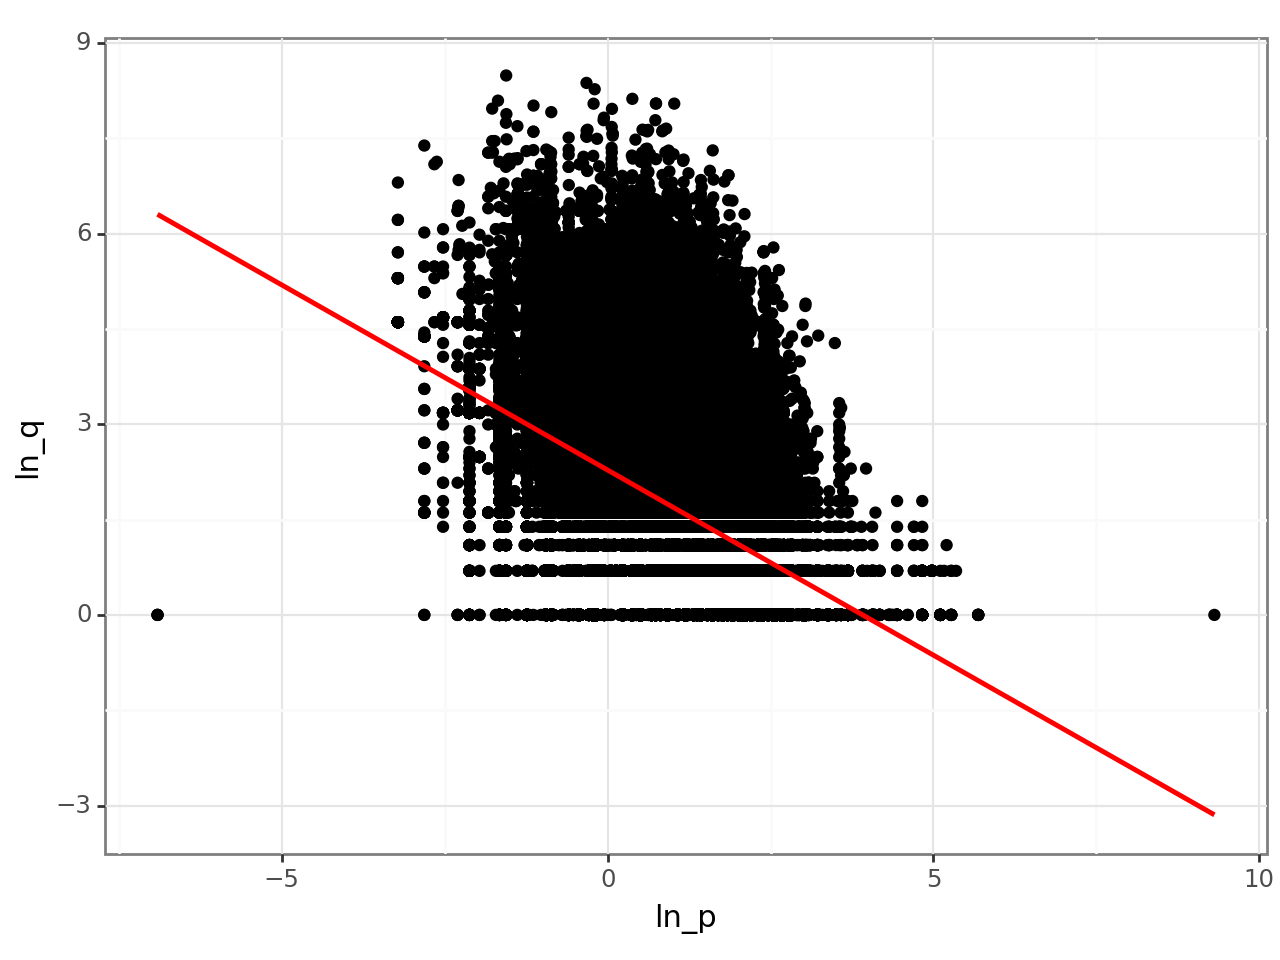

<Figure Size: (640 x 480)>

In [12]:
df = df.assign(
    ln_p = np.log(df['UnitPrice']),
    ln_q = np.log(df['Quantity']),
)

(p9.ggplot(df, p9.aes('ln_p','ln_q')) + p9.geom_point() + p9.stat_smooth(color="red"))

In [15]:
result = sm.ols('ln_q ~ ln_p ', data=df).fit() # + C(subcat)
print('Elasticity: {}, SE: {}, R2: {}'.format(result.params['ln_p'],result.bse['ln_p'], result.rsquared_adj))
result.conf_int(alpha=0.05)

Elasticity: -0.5824409672169055, SE: 0.0023543585962255806, R2: 0.1702738854533692


,0,1
Intercept,2.273241,2.284308
ln_p,-0.587055,-0.577826


# A practical introduction to BERT

In the next part of the notebook, we are going to explore how a tool like BERT may be useful for causal inference.

In particular, we are going to apply BERT to a subset of data from the Amazon marketplace consisting of roughly 10,000 listings for products in the toy category. Each product comes with a text description, a price, and a number of times reviewed (which we'll use as a proxy for demand / market share).

For more information on the dataset, checkout the [Dataset README](https://github.com/CausalAIBook/MetricsMLNotebooks/blob/main/data/amazon_toys.md).

**Problem 1**:
What are some issues you may anticipate when using number of reviews as a proxy for demand or market share?

### Getting to know the data

First, we'll download and clean up the data, and do some preliminary inspection.

In [ ]:
DATA_URL = 'https://github.com/CausalAIBook/MetricsMLNotebooks/raw/main/data/amazon_toys.csv'
data = pd.read_csv(DATA_URL)

In [ ]:
data.columns

Index(['uniq_id', 'product_name', 'manufacturer', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'amazon_category_and_sub_category',
       'customers_who_bought_this_item_also_bought', 'description',
       'product_information', 'product_description',
       'items_customers_buy_after_viewing_this_item',
       'customer_questions_and_answers', 'customer_reviews', 'sellers'],
      dtype='object')

8872    1,040
Name: number_of_reviews, dtype: object

In [ ]:
# Clean numeric data fields (remove all non-digit characters and parse as a numeric value)

data['number_of_reviews'] = pd.to_numeric(data
                                          .number_of_reviews
                                          .str.replace(',', '', regex=True)
                                          .str.replace(r"\D+", '', regex=True))

data['price'] = (data
                    .price
                    .str.extract(r'(\d+\.*\d+)')
                    .astype('float'))

# Drop products with very few reviews
data = data[data['number_of_reviews'] > 0]

# Compute log prices
data['ln_p'] = np.log(data.price)

# Impute market shares from # of reviews
data['ln_q'] =  np.log(data['number_of_reviews'] / data['number_of_reviews'].sum())

# Collect relevant text data
data['text'] = (data[[
                    'product_name',
                    'manufacturer',
                    'product_description'
                    ]]
                  .astype('str')
                  .agg(' | '.join, axis=1))

#  Drop irrelevant data and inspect
data = data[['text','ln_p','ln_q', 'amazon_category_and_sub_category']]
data = data.dropna()
data.head()

,text,ln_p,ln_q,amazon_category_and_sub_category
0,Hornby 2014 Catalogue | Hornby | Product Descr...,1.229641,-8.713144,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys® Large Christmas Holiday Express Fes...,2.832625,-10.728047,Hobbies > Model Trains & Railway Sets > Rail V...
2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,2.301585,-8.587981,Hobbies > Model Trains & Railway Sets > Rail V...
3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd...,3.688629,-11.421194,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,3.471656,-10.322582,Hobbies > Model Trains & Railway Sets > Rail V...


313.97999999999956


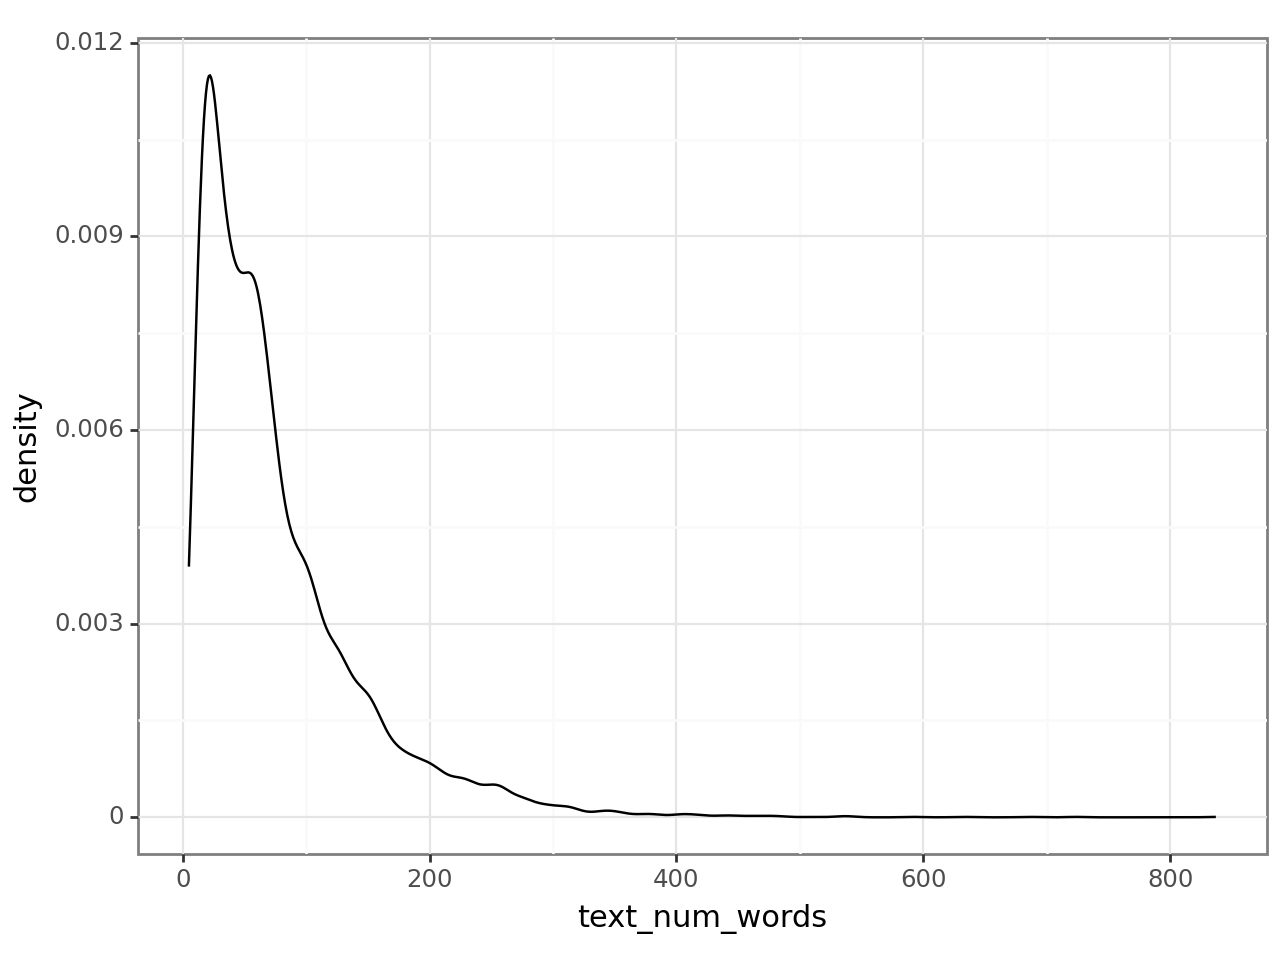

<Figure Size: (640 x 480)>

Let's make a two-way scatter plot of prices and (proxied) market shares.

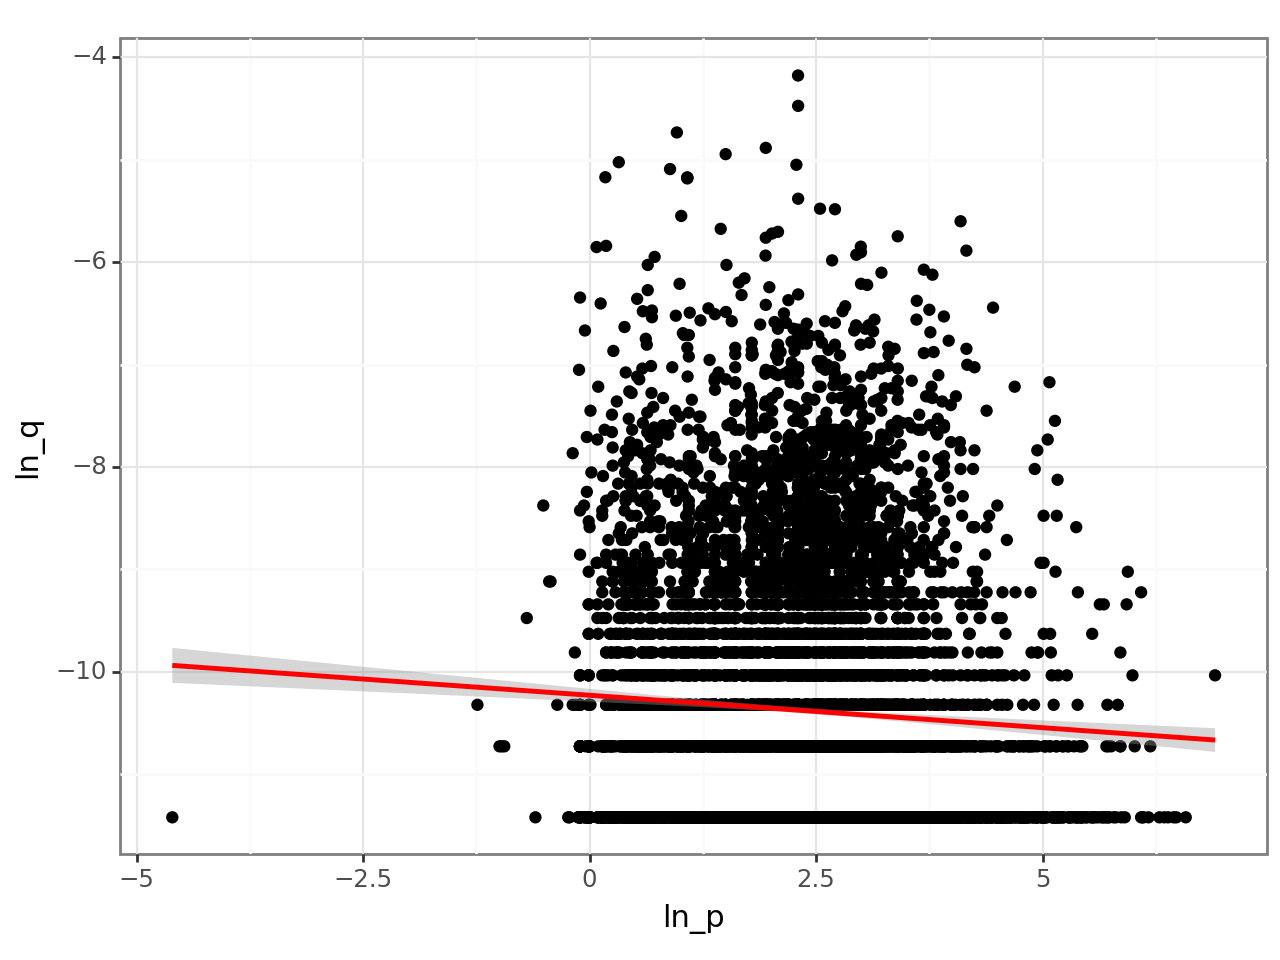

<Figure Size: (640 x 480)>

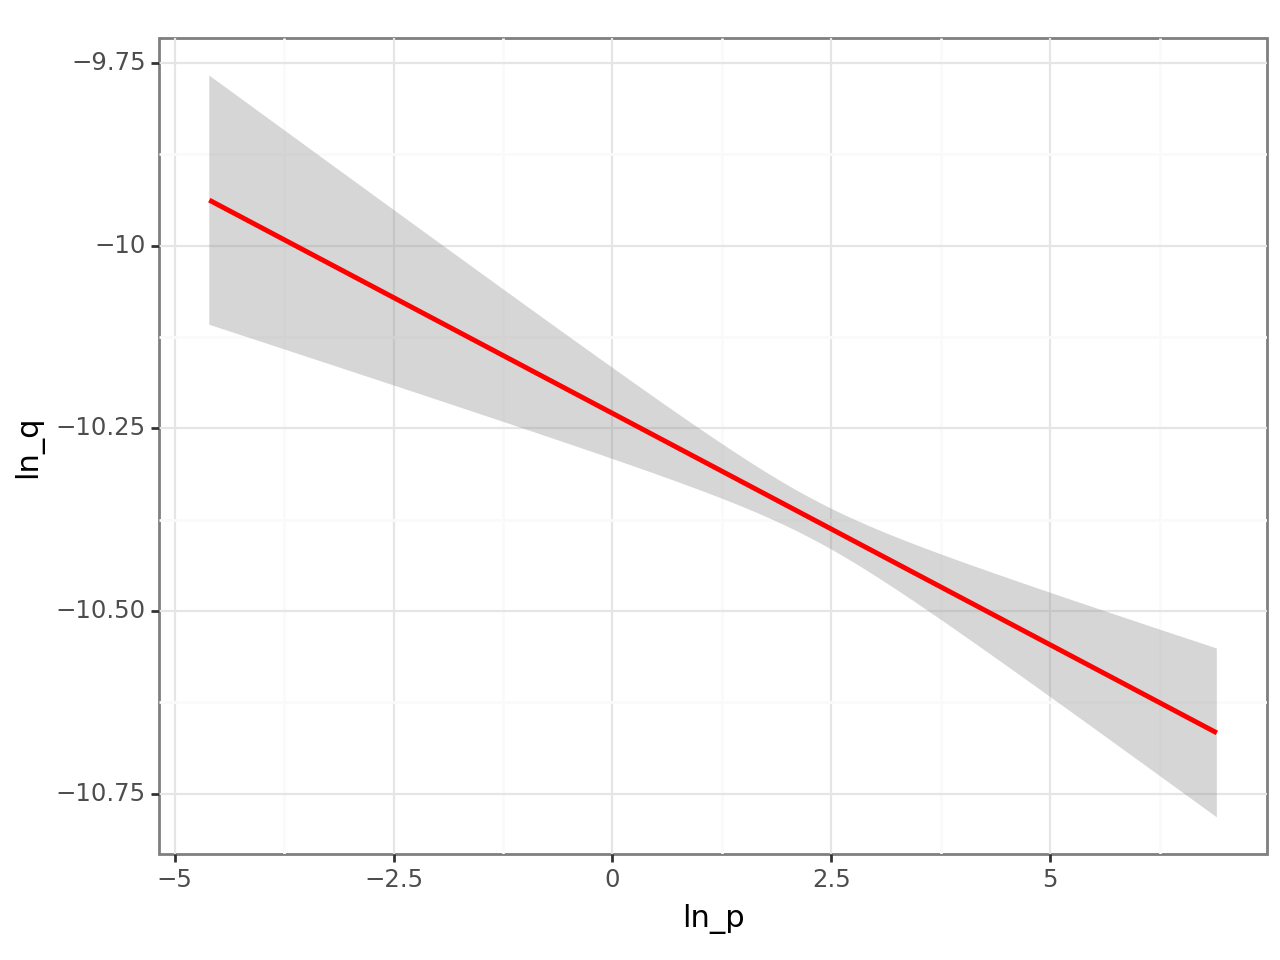

<Figure Size: (640 x 480)>

Elasticity: -0.06334293251006756, SE: 0.01243547631340123, R2: 0.0031077901369295224


,0,1
Intercept,-10.291813,-10.167009
ln_p,-0.087720,-0.038966


Let's begin with a simple prediction task. We will discover how well can we explain the price of these products using their textual descriptions.

**Problem 2**:
 1. Build a linear model that explains the price of each product using it's text embedding vector as the explanatory variables.

 2. Build a two-layer perceptron neural network that explains the price of each product using the text embedding vector as input (see example code below).
<!-- 3. Now, instead of taking the text embeddings as fixed, we allow the it to ``fine tune.'' Construct a neural network by combining the (pre-loaded) BERT network -->

 3. Report the $R^2$ of both approaches.

In [ ]:
from sklearn.model_selection import train_test_split

main_ind, test_ind = train_test_split(np.arange(data.shape[0]), test_size=.2, shuffle=True, random_state=124)
main = data.iloc[main_ind]

train_ind, val_ind = train_test_split(np.arange(main.shape[0]), test_size=0.25, random_state=124) # 0.25 x 0.8 = 0.2

train = main.iloc[train_ind]
val = main.iloc[val_ind]
holdout = data.iloc[test_ind]

tensors = tokenizer(
    list(train["text"]),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf")

val_tensors = tokenizer(
    list(val["text"]),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf")

# Preprocess holdout sample
tensors_holdout = tokenizer(
    list(holdout["text"]),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf")

In [ ]:
ln_p = train["ln_p"]
ln_q = train["ln_q"]
val_ln_p = val["ln_p"]
val_ln_q = val["ln_q"]

# Using BERT as Feature Extractor

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, Concatenate
import tensorflow_addons as tfa
from tensorflow.keras import regularizers

input_ids = Input(shape=(128,), dtype=tf.int32)
token_type_ids = Input(shape=(128,), dtype=tf.int32)
attention_mask = Input(shape=(128,), dtype=tf.int32)

Z = bert(input_ids, token_type_ids, attention_mask)[1]

embedding_model = Model([input_ids, token_type_ids, attention_mask], Z)

embeddings = embedding_model.predict([tensors['input_ids'], tensors['token_type_ids'], tensors['attention_mask']])

151/151 [==============================] - 9s 39ms/step


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lcv = make_pipeline(StandardScaler(), LassoCV(cv=KFold(n_splits=5, shuffle=True, random_state=123), random_state=123))
lcv.fit(embeddings, ln_p)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv',
                 LassoCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                         random_state=123))])

In [ ]:
embeddings_val = embedding_model.predict([val_tensors['input_ids'], val_tensors['token_type_ids'], val_tensors['attention_mask']])

51/51 [==============================] - 2s 39ms/step


In [ ]:
get_r2(val_ln_p, lcv.predict(embeddings_val))

RSS: 1250.351476330944, TSS + MEAN^2: 10640.194498799881, TSS: 2035.8884883484386, R^2: 0.38584481248024594


In [ ]:
embeddings_holdout = embedding_model.predict([tensors_holdout['input_ids'], tensors_holdout['token_type_ids'], tensors_holdout['attention_mask']])

51/51 [==============================] - 2s 38ms/step


In [ ]:
get_r2(holdout['ln_p'], lcv.predict(embeddings_holdout))

RSS: 1260.4281590904234, TSS + MEAN^2: 10522.713393336924, TSS: 2057.4150271276617, R^2: 0.38737292064494366


In [ ]:
ln_p_hat_holdout = lcv.predict(embeddings_holdout)

# Linear Probing: Training Only Final Layer after BERT

In [ ]:
### Now let's prepare our model

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, Concatenate
import tensorflow_addons as tfa
from tensorflow.keras import regularizers

tf.keras.utils.set_random_seed(123)

input_ids = Input(shape=(128,), dtype=tf.int32)
token_type_ids = Input(shape=(128,), dtype=tf.int32)
attention_mask = Input(shape=(128,), dtype=tf.int32)

# # First we compute the text embedding
Z = bert(input_ids, token_type_ids, attention_mask)

for layer in bert.layers:
    layer.trainable=False
    for w in layer.weights: w._trainable=False

# # We want the "pooled / summary" embedding, not individual word embeddings
Z = Z[1]

# # Then we do a regular regression
# Z = Dropout(0.2)(Z)
ln_p_hat = Dense(1, activation='linear',
                 kernel_regularizer=regularizers.L2(1e-3))(Z)

PricePredictionNetwork = Model([
                                input_ids,
                                token_type_ids,
                                attention_mask,
                                ], ln_p_hat)
PricePredictionNetwork.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tfa.metrics.RSquare(),
)
PricePredictionNetwork.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_4[0][0]',                
                                thPoolingAndCrossAt               'input_5[0][0]',          

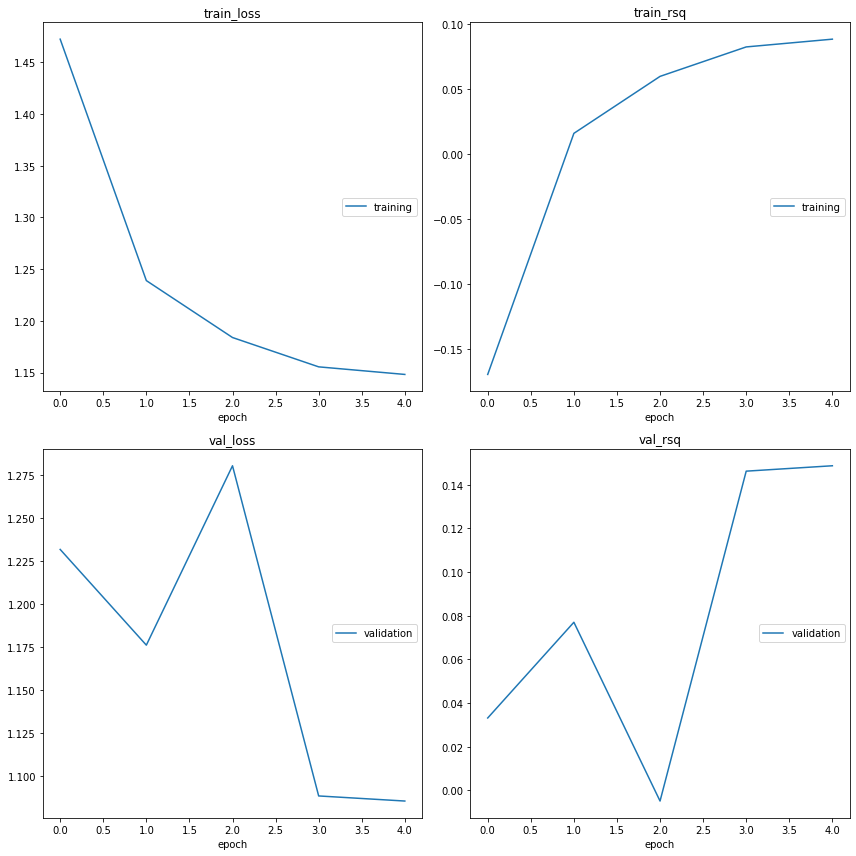

train_loss
	training         	 (min:    1.148, max:    1.472, cur:    1.148)
train_rsq
	training         	 (min:   -0.170, max:    0.089, cur:    0.089)
val_loss
	validation       	 (min:    1.085, max:    1.280, cur:    1.085)
val_rsq
	validation       	 (min:   -0.005, max:    0.149, cur:    0.149)
301/301 [==============================] - 14s 48ms/step - loss: 1.1483 - r_square: 0.0887 - val_loss: 1.0853 - val_r_square: 0.1487


In [ ]:
from livelossplot import PlotLossesKeras

tf.keras.utils.set_random_seed(123)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/pweights.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True)

PricePredictionNetwork.fit(
                x= [tensors['input_ids'],
                    tensors['token_type_ids'],
                    tensors['attention_mask'],],
                y=ln_p,
                validation_data = (
                    [val_tensors['input_ids'],
                     val_tensors['token_type_ids'],
                     val_tensors['attention_mask']], val_ln_p
                ),
                epochs=5,
                callbacks = [earlystopping, modelcheckpoint,
                             PlotLossesKeras(groups = {'train_loss': ['loss'], 'train_rsq':['r_square'], 'val_loss': ['val_loss'], 'val_rsq': ['val_r_square']})],
                batch_size=16,
                shuffle=True)

# Fine Tuning starting from the Linear Probing Trained Weights

Now we train the whole network, initializing the weights based on the result of the linear probing phase in the previous section.

In [ ]:
### Now let's prepare our model

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, Concatenate
import tensorflow_addons as tfa
from tensorflow.keras import regularizers

tf.keras.utils.set_random_seed(123)

input_ids = Input(shape=(128,), dtype=tf.int32)
token_type_ids = Input(shape=(128,), dtype=tf.int32)
attention_mask = Input(shape=(128,), dtype=tf.int32)

# # First we compute the text embedding
Z = bert(input_ids, token_type_ids, attention_mask)

for layer in bert.layers:
    layer.trainable=True
    for w in layer.weights: w._trainable=True

# # We want the "pooled / summary" embedding, not individual word embeddings
Z = Z[1]

# # Then we do a regularized linear regression
ln_p_hat = Dense(1, activation='linear',
                 kernel_regularizer=regularizers.L2(1e-3))(Z)

PricePredictionNetwork = Model([
                                input_ids,
                                token_type_ids,
                                attention_mask,
                                ], ln_p_hat)
PricePredictionNetwork.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tfa.metrics.RSquare(),
)
PricePredictionNetwork.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]',          

In [ ]:
PricePredictionNetwork.load_weights("/content/gdrive/MyDrive/pweights.hdf5")

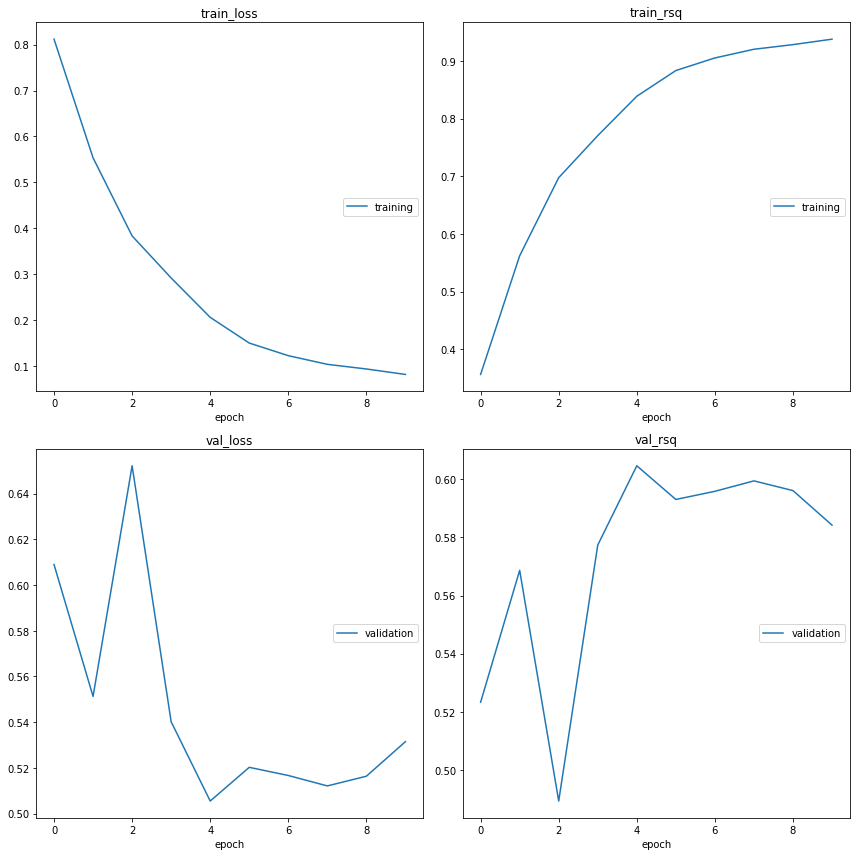

train_loss
	training         	 (min:    0.081, max:    0.812, cur:    0.081)
train_rsq
	training         	 (min:    0.356, max:    0.938, cur:    0.938)
val_loss
	validation       	 (min:    0.506, max:    0.652, cur:    0.531)
val_rsq
	validation       	 (min:    0.489, max:    0.605, cur:    0.584)
301/301 [==============================] - 25s 83ms/step - loss: 0.0813 - r_square: 0.9376 - val_loss: 0.5315 - val_r_square: 0.5842


In [ ]:
from livelossplot import PlotLossesKeras

tf.keras.utils.set_random_seed(123)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/pweights.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True)

PricePredictionNetwork.fit(
                x= [tensors['input_ids'],
                    tensors['token_type_ids'],
                    tensors['attention_mask'],],
                y=ln_p,
                validation_data = (
                    [val_tensors['input_ids'],
                     val_tensors['token_type_ids'],
                     val_tensors['attention_mask']], val_ln_p
                ),
                epochs=10,
                callbacks = [earlystopping, modelcheckpoint,
                             PlotLossesKeras(groups = {'train_loss': ['loss'], 'train_rsq':['r_square'], 'val_loss': ['val_loss'], 'val_rsq': ['val_r_square']})],
                batch_size=16,
                shuffle=True)

In [ ]:
PricePredictionNetwork.load_weights("/content/gdrive/MyDrive/pweights.hdf5")

In [ ]:
# Compute predictions
ln_p_hat_holdout = PricePredictionNetwork.predict([
                                                   tensors_holdout['input_ids'],
                                                   tensors_holdout['token_type_ids'],
                                                   tensors_holdout['attention_mask'],
                                                   ])

51/51 [==============================] - 5s 40ms/step


In [ ]:
print('Neural Net R^2, Price Prediction:')
get_r2(holdout['ln_p'], ln_p_hat_holdout)

Neural Net R^2, Price Prediction:
RSS: 789.9447435913809, TSS + MEAN^2: 10522.713393336924, TSS: 2057.4150271276617, R^2: 0.6160498814406856


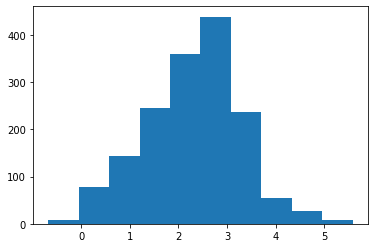

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ln_p_hat_holdout)
plt.show()

Now, let's go one step further and construct a DML estimator of the average price elasticity. In particular, we will model market share $q_i$ as
$$\ln q_i = \alpha + \beta \ln p_i + \psi(d_i) + \epsilon_i,$$ where $d_i$ denotes the description of product $i$ and $\psi$ is the composition of text embedding and a linear layer.

**Problem 3**:
 1. Split the sample in two, and predict $\ln p_i$ and $\ln q_i$ using $d_i$ with a two-layer perceptron as before, using the main sample.
 2. In the holdout sample, perform an OLS regression of the residual of $\ln q_i$ on the residual of $\ln p_i$ (using the previous problem's model).
 3. What do you find?

In [ ]:
## Build the quantity prediction network

tf.keras.utils.set_random_seed(123)

# Initialize new BERT model from original
bert2 = TFBertModel.from_pretrained("bert-base-uncased")

# for layer in bert2.layers:
#     layer.trainable=False
#     for w in layer.weights: w._trainable=False

# Define inputs
input_ids = Input(shape=(128,), dtype=tf.int32)
token_type_ids = Input(shape=(128,), dtype=tf.int32)
attention_mask = Input(shape=(128,), dtype=tf.int32)

# First we compute the text embedding
Z = bert2(input_ids, token_type_ids, attention_mask)

# We want the "pooled / summary" embedding, not individual word embeddings
Z = Z[1]

ln_q_hat = Dense(1, activation='linear', kernel_regularizer=regularizers.L2(1e-3))(Z)

# Compile model and optimization routine
QuantityPredictionNetwork = Model([
                                   input_ids,
                                   token_type_ids,
                                   attention_mask,
                                   ], ln_q_hat)
QuantityPredictionNetwork.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tfa.metrics.RSquare(),
)
QuantityPredictionNetwork.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_10[0][0]',               
                                thPoolingAndCrossAt               'input_11[0][0]',         

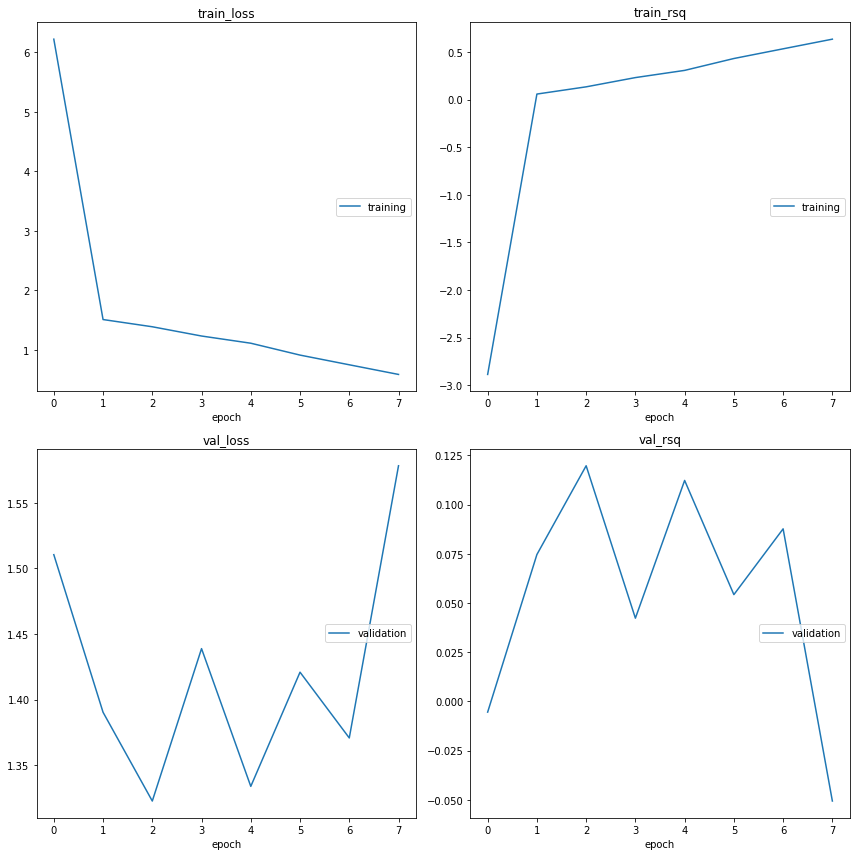

train_loss
	training         	 (min:    0.589, max:    6.221, cur:    0.589)
train_rsq
	training         	 (min:   -2.886, max:    0.634, cur:    0.634)
val_loss
	validation       	 (min:    1.323, max:    1.578, cur:    1.578)
val_rsq
	validation       	 (min:   -0.051, max:    0.120, cur:   -0.051)
301/301 [==============================] - 25s 83ms/step - loss: 0.5885 - r_square: 0.6335 - val_loss: 1.5783 - val_r_square: -0.0506


In [ ]:
## Fit the quantity prediction network in the main sample
tf.keras.utils.set_random_seed(123)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/qweights.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True)

QuantityPredictionNetwork.fit(
                [
                 tensors['input_ids'],
                 tensors['token_type_ids'],
                 tensors['attention_mask'],
                 ],
                ln_q,
                validation_data = (
                    [val_tensors['input_ids'],
                 val_tensors['token_type_ids'],
                 val_tensors['attention_mask']], val_ln_q
                ),
                epochs=10,
                callbacks = [earlystopping, modelcheckpoint,
                             PlotLossesKeras(groups = {'train_loss': ['loss'], 'train_rsq':['r_square'], 'val_loss': ['val_loss'], 'val_rsq': ['val_r_square']})],
                batch_size=16,
                shuffle=True)

In [ ]:
QuantityPredictionNetwork.load_weights("/content/gdrive/MyDrive/qweights.hdf5")

In [ ]:
## Predict in the holdout sample, residualize and regress

ln_q_hat_holdout = QuantityPredictionNetwork.predict([
                                                      tensors_holdout['input_ids'],
                                                      tensors_holdout['token_type_ids'],
                                                      tensors_holdout['attention_mask'],
                                                      ])

51/51 [==============================] - 5s 39ms/step


In [ ]:
print('Neural Net R^2, Quantity Prediction:')
get_r2(holdout['ln_q'], ln_q_hat_holdout)

Neural Net R^2, Quantity Prediction:
RSS: 2209.611281622743, TSS + MEAN^2: 174764.43693197635, TSS: 2488.879451114385, R^2: 0.11220638643892589


In [ ]:
# Compute residuals
r_p = holdout["ln_p"] - ln_p_hat_holdout.reshape((-1,))
r_q = holdout["ln_q"] - ln_q_hat_holdout.reshape((-1,))

# Regress to obtain elasticity estimate
beta = np.mean(r_p * r_q) / np.mean(r_p * r_p)

# standard error on elastiticy estimate
se = np.sqrt(np.mean( (r_p* r_q)**2)/(np.mean(r_p*r_p)**2)/holdout["ln_p"].size)

print('Elasticity of Demand with Respect to Price: {}'.format(beta))
print('Standard Error: {}'.format(se))

Elasticity of Demand with Respect to Price: -0.0654279560683773
Standard Error: 0.039235091954966266


# Heterogeneous Elasticities within Major Product Categories

We now look at the major product categories that have many products and we investigate whether the "within group" price elasticities

In [ ]:
holdout['category'] = holdout['amazon_category_and_sub_category'].str.split('>').apply(lambda x: x[0])

In [ ]:
# Elasticity within the main product categories
sql.run("""
  SELECT category, COUNT(*)
  FROM holdout
  GROUP BY 1
  HAVING COUNT(*)>=100
  ORDER BY 2 desc
""")

,category,COUNT(*)
0,Hobbies,251
1,Die-Cast & Toy Vehicles,209
2,Figures & Playsets,172
3,Games,162
4,Characters & Brands,154
5,Arts & Crafts,140
6,Party Supplies,136


In [ ]:
main_cats = sql.run("""
  SELECT category
  FROM holdout
  GROUP BY 1
  HAVING COUNT(*)>=100
""")['category']

dfs = []
for cat in main_cats:
    r_p = holdout[holdout['category'] == cat]["ln_p"] - ln_p_hat_holdout.reshape((-1,))[holdout['category'] == cat]
    r_q = holdout[holdout['category'] == cat]["ln_q"] - ln_q_hat_holdout.reshape((-1,))[holdout['category'] == cat]
    # Regress to obtain elasticity estimate
    beta = np.mean(r_p * r_q) / np.mean(r_p * r_p)

    # standard error on elastiticy estimate
    se = np.sqrt(np.mean( (r_p* r_q)**2)/(np.mean(r_p*r_p)**2)/holdout["ln_p"].size)

    df = pd.DataFrame({'point': beta, 'se': se, 'lower': beta - 1.96 * se, 'upper': beta + 1.96 * se}, index=[0])
    df['category'] = cat
    df['N'] = holdout[holdout['category'] == cat].shape[0]
    dfs.append(df)

df = pd.concat(dfs)
df

,point,se,lower,upper,category,N
0,-0.112472,0.060480,-0.231013,0.006070,Arts & Crafts,140
0,0.084301,0.053467,-0.020494,0.189097,Characters & Brands,154
0,0.039444,0.027593,-0.014639,0.093526,Die-Cast & Toy Vehicles,209
0,0.000310,0.030479,-0.059429,0.060049,Figures & Playsets,172
0,-0.162961,0.045047,-0.251253,-0.074669,Games,162
0,-0.025897,0.024416,-0.073753,0.021959,Hobbies,251
0,-0.347834,0.045676,-0.437360,-0.258309,Party Supplies,136


## Clustering Products

In this final part of the notebook, we'll illustrate how the BERT text embeddings can be used to cluster products based on their  descriptions.

Intiuitively, our neural network has now learned which aspects of the text description are relevant to predict prices and market shares.
We can therefore use the embeddings produced by our network to cluster products, and we might expect that the clusters reflect market-relevant information.

In the following block of cells, we compute embeddings using our learned models and cluster them using $k$-means clustering with $k=10$. Finally, we will explore how the estimated price elasticity differs across clusters.

### Overview of **$k$-means clustering**
The $k$-means clustering algorithm seeks to divide $n$ data vectors into $k$ groups, each of which contain points that are "close together."

In particular, let $C_1, \ldots, C_k$ be a partitioning of the data into $k$ disjoint, nonempty subsets (clusters), and define
$$\bar{C_i}=\frac{1}{\#C_i}\sum_{x \in C_i} x$$
to be the *centroid* of the cluster $C_i$. The $k$-means clustering score $\mathrm{sc}(C_1 \ldots C_k)$ is defined to be
$$\mathrm{sc}(C_1 \ldots C_k) = \sum_{i=1}^k \sum_{x \in C_i} \left(x - \bar{C_i}\right)^2.$$

The $k$-means clustering is then defined to be any partitioning $C^*_1 \ldots C^*_k$ that minimizes the score $\mathrm{sc}(-)$.

**Problem 4** Show that the $k$-means clustering depends only on the pairwise distances between points. *Hint: verify that $\sum_{x,y \in C_i} (x - \bar{C_i})(y - \bar{C_i}) = 0$.*

In [ ]:
## STEP 1: Compute embeddings

input_ids = Input(shape=(128,), dtype=tf.int32)
token_type_ids = Input(shape=(128,), dtype=tf.int32)
attention_mask = Input(shape=(128,), dtype=tf.int32)

Y1 = bert(input_ids, token_type_ids, attention_mask)[1]
Y2 = bert2(input_ids, token_type_ids, attention_mask)[1]
Y = Concatenate()([Y1,Y2])

embedding_model = Model([input_ids, token_type_ids, attention_mask], Y)

embeddings = embedding_model.predict([tensors_holdout['input_ids'],
                                      tensors_holdout['token_type_ids'],
                                      tensors_holdout['attention_mask']])

51/51 [==============================] - 10s 61ms/step


### Dimension reduction and the **Johnson-Lindenstrauss transform**

Our learned embeddings have dimension in the $1000$s, and $k$-means clustering is often an expensive operation. To improve the situation, we will use a neat trick that is used extensively in machine learning applications: the *Johnson-Lindenstrauss transform*.

This trick involves finding a low-dimensional linear projection of the embeddings that approximately preserves pairwise distances.

In fact, Johnson and Lindenstrauss proved a much more interesting statement: a Gaussian random matrix will *almost always* approximately preserve pairwise distances.

**Problem 5** Suppose we have a low-dimensional projection matrix $\Pi$ that preserves pairwise distances, and let $X$ be the design matrix. Explain how and why we could compute the $k$-means clustering using only the projected data $\Pi X$. *Hint: use Problem 4.*



In [ ]:
# STEP 2 Make low-dimensional projections
from sklearn.random_projection import GaussianRandomProjection

jl = GaussianRandomProjection(eps=.25)
embeddings_lowdim = jl.fit_transform(embeddings)

In [ ]:
# STEP 3 Compute clusters
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10)
k_means.fit(embeddings_lowdim)
cluster_ids = k_means.labels_

In [ ]:
# STEP 4 Regress within each cluster

betas = np.zeros(10)
ses = np.zeros(10)

r_p = holdout["ln_p"] - ln_p_hat_holdout.reshape((-1,))
r_q = holdout["ln_q"] - ln_q_hat_holdout.reshape((-1,))

for c in range(10):

  r_p_c = r_p[cluster_ids == c]
  r_q_c = r_q[cluster_ids == c]

  # Regress to obtain elasticity estimate
  betas[c] = np.mean(r_p_c * r_q_c) / np.mean(r_p_c * r_p_c)

  # standard error on elastiticy estimate
  ses[c] = np.sqrt(np.mean( (r_p_c * r_q_c)**2)/(np.mean(r_p_c*r_p_c)**2)/r_p_c.size)

<BarContainer object of 10 artists>

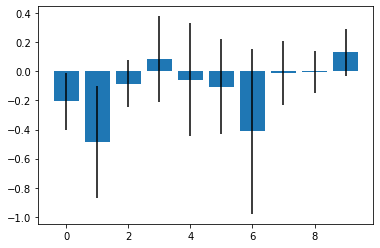

In [ ]:
# STEP 5 Plot
from matplotlib import pyplot as plt

plt.bar(range(10), betas, yerr = 1.96 * ses)